In this notebook we explore the ability of inhibition to control a network with recurrent excitation.

# Bistability of recurrent excitatory ntwk

Starting with a population of PCs we show that once a certain level of recurrent excitation is reached the ntwk becomes bistable, exhibiting a zero-valued and high-valued population activity fixed point.

In [1]:
%reset -f
%matplotlib inline
from copy import copy
import matplotlib.pyplot as plt
import numpy as np

from aux import downsample_ma
from ntwk import LIFNtwk
from plot import set_font_size

import PARAMETERS as P

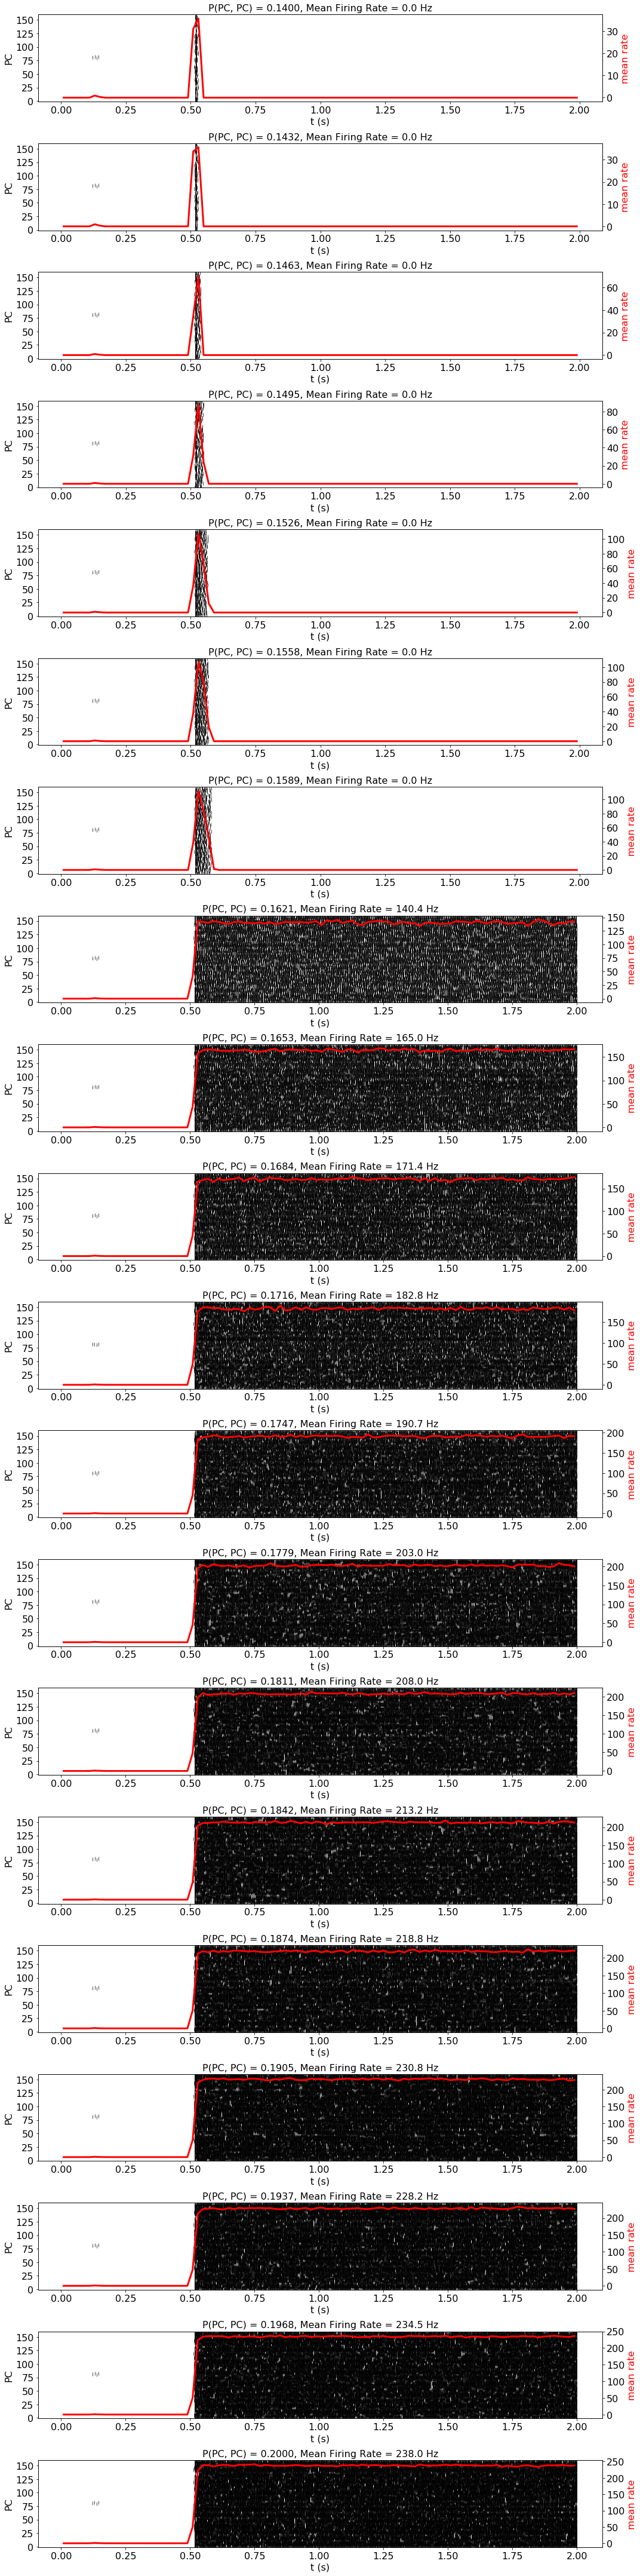

In [2]:
P_PC_PCS = np.linspace(.14, .2, 20)

N_PC = 160

DUR = 2

ITVL_LOW = (0.1, 0.15)
N_LOW = 3
RATE_LOW = 500

ITVL_HIGH = (.5, .52)
N_HIGH = 160
RATE_HIGH = 500

ITVL_REC = (1, 2)
DT_DOWN = 0.02

AX_HEIGHT = 3

# FIXED NTWK PROPERTIES
NTWK_KWARGS = {
    't_m': P.T_M_PC,  # (s)
    'e_leak': P.E_L_PC,  # (V)
    'v_th': P.V_TH_PC,  # (V)
    'v_reset': P.V_RESET_PC,  # (V)
    't_r': P.T_R,  # (s)
    'es_syn': {'AMPA': P.E_A},  # (V)
    'ts_syn': {'AMPA': P.T_A},  # (s)
    'ws_up': {'AMPA': P.W_A_PC_PL * np.eye(N_PC)}
}

# make stim
np.random.seed(0)

ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), N_PC))

# low stimulus
mask_low = (ts >= ITVL_LOW[0])&(ts < ITVL_LOW[1])
spks_up[mask_low, N_PC//2:N_PC//2 + N_LOW] = np.random.poisson(
    RATE_LOW*P.DT, (mask_low.sum(), N_LOW))

# high stimulus
mask_high = (ts >= ITVL_HIGH[0])&(ts < ITVL_HIGH[1])
spks_up[mask_high, :N_HIGH] = np.random.poisson(
    RATE_HIGH*P.DT, (mask_high.sum(), N_HIGH))
    
vs_init = P.E_L_PC * np.ones(N_PC)

n_down = int(DUR/DT_DOWN)

# loop over PC-PC connectivity levels
fig_size = (15, AX_HEIGHT*len(P_PC_PCS))
fig, axs = plt.subplots(len(P_PC_PCS), 1, figsize=fig_size, tight_layout=True, squeeze=False)
axs = axs[:, 0]

for p_pc_pc, ax in zip(P_PC_PCS, axs):

    # make recurrent PC cxns
    w_mask_pc_pc = np.random.rand(N_PC, N_PC) < p_pc_pc
    # set self-cxns to zero
    np.fill_diagonal(w_mask_pc_pc, False)
    
    # make weight matrix
    w_pc_pc = np.zeros((N_PC, N_PC))
    w_pc_pc[w_mask_pc_pc] = P.W_A_PC_PC
    
    # make ntwk
    ntwk_kwargs = copy(NTWK_KWARGS)
    ntwk_kwargs['ws_rcr'] = {'AMPA': w_pc_pc}
    
    ntwk = LIFNtwk(**ntwk_kwargs)
    
    # run ntwk
    resp = ntwk.run(spks_up, P.DT, vs_init)
    
    # plot response raster
    spk_times, spk_idxs = resp.spks.nonzero()
    spk_times = spk_times * P.DT
    
    ax.scatter(spk_times, spk_idxs, marker='|', lw=0.7, color='k', zorder=-1)
    
    ax.set_xlim(ts[0], ts[-1])
    ax.set_ylim(-1, N_PC)
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('PC')
    
    # plot mean firing rate
    mean_rate_down = downsample_ma(resp.spks.mean(1)/P.DT, n_down)
    ts_down = downsample_ma(ts, n_down)
    
    ax_twin = ax.twinx()
    ax_twin.plot(ts_down, mean_rate_down, lw=3, color='r', zorder=1)
    ax_twin.set_ylabel('mean rate', color='r')
    
    mean_rate = resp.spks[(ts >= ITVL_REC[0])*(ts < ITVL_REC[1])].sum(0).mean() / (ITVL_REC[1] - ITVL_REC[0])
    
    ax.set_title('P(PC, PC) = {0:.4f}, Mean Firing Rate = {1:.1f} Hz'.format(p_pc_pc, mean_rate))
    
    for ax_ in [ax, ax_twin]:
        set_font_size(ax_, 16)